In [ ]:
import numpy as np
import scipy.io as sio
import berkeley_util as butil 
from scipy.spatial.distance import cdist
import pandas as pd
import matplotlib.pyplot as plt
import json

In [ ]:
def loading(ID,walkNum,walktype):
    
    dataset = []
    for x in walkNum:
        loc = '/N/project/berkeley_walking/BerkeleyData/berkeley_json'
        with open(f'{loc}/s{str(ID)}_{x}_{str(walktype)}_allWalks.json', "r") as f:
                data = json.load(f)
        with open(f'{loc}/s{str(ID)}_{x}_{str(walktype)}_allWalks.json', "w") as f:
                json.dump(data,f)
        dataset.append(data)
    return dataset


def extract_fix(dataset):

    f_start = []
    f_stop = []
    fix_df = []
    for x in dataset:
        
        framerate = x['framerate']
        frames,time= np.array(x['frames']),np.array(x['syncedUnixTime'])
        time = time -time[0]
        fixation,theta = np.array(x['rEye_blinks'], dtype = bool),np.array(x['rEye_theta'])
        theta_fix = np.array(x['rEye_theta'])
        theta_fix[fixation] = np.nan
        fixations_df = pd.DataFrame({ 'Frames': frames, 'Time': time, 'Theta': theta,
                             'ThetaFix': theta_fix})

        fixations_df = fixations_df.dropna()
        fixations_df['TimeDiffPrev'],   fixations_df['TimeDiffFol'] = fixations_df['Time'].diff(), fixations_df['Time'].diff(periods=-1)
        fix_stop, fix_start = fixations_df.loc[fixations_df['TimeDiffPrev'] > 0.009], fixations_df.loc[fixations_df['TimeDiffFol'] < -0.009]
        fix_df.append(fixations_df)
        f_start.append(fix_start)
        f_stop.append(fix_stop)
        
    return fix_df, f_stop, f_start

def extract_steps(dataset):

    steps_df = []
    for x in dataset:
        
        framerate = x['framerate']
        steps = np.array(x['steps_HS_TO_StanceLeg_XYZ'])
        step_start, step_end = steps[:,0].astype(int), steps[:,1].astype(int)
        step_start_time, step_end_time = step_start / framerate, step_end / framerate
        step_frames = steps[:,0:2].astype(int)
        step_time = step_frames.T / framerate

        steps = pd.DataFrame({'FrameStart': steps[:,0], 'FrameEnd': steps[:,1], 'Foot':steps[:,2],
                         'X': steps[:,3],  'Y': steps[:,4],  'Z' :steps[:,5]})

        steps['StartTime'],steps['EndTime'] = step_start_time, step_end_time
        steps_df.append(steps)

    return steps_df

In [ ]:
def find_closest_hs(fixations,steps, stop, start):

    closest_hs_df = []
    closest_hs = []
    fstart = []
    fstop = []
    for x, y,e,s in zip(fixations,steps,stop,start):
        fixStart, fixEnd, footfalls = np.array(s['Time']),np.array(e['Time']), np.array(y['StartTime'])
        footfalls, fixStart, fixStop  = footfalls.reshape(-1,1), fixStart.reshape(-1,1), fixEnd.reshape(-1,1)
        fstart.append(fixStart)
        fstop.append(fixStop)

        from sklearn.neighbors import NearestNeighbors
        X = footfalls
        Start = fixStart

        neigh = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(X)
        start_distances, start_indices = neigh.kneighbors(Start)
        startNearest = np.array(start_indices)

        closest_heelstrike_time = footfalls[startNearest]
        closest_heelstrike_time = closest_heelstrike_time[:,0]
        closest_hs.append(closest_heelstrike_time)
        closest = pd.DataFrame(closest_heelstrike_time, columns = ['TimeNearFixStart'])
        closest['IndexNearFixStart'] = startNearest
        closest_hs_df.append(closest)
        
    return closest_hs, fstart, fstop, closest_hs_df

In [ ]:

def calc_rel_fix(closest_hs, fstart, fstop):
    
    rel_start = []
    rel_stop = []
    for x,st in zip(closest_hs,fstart):
            r = x - st
            rel_start.append(r)

    for x,sp in zip(closest_hs,fstop):
        r = x - sp
        rel_stop.append(r)

        rel_start_ar = []
        rel_stop_ar = []
        for x, y in zip(rel_start,rel_stop):
            x,y = np.array(x), np.array(y)
            rel_start_ar.append(x)
            rel_stop_ar.append(y)
        
            rel_fix_df = []
            for x,y in zip(rel_start_ar,rel_stop_ar):
                x,y = x[:,0], y[:,0]
                rfixtimes = pd.DataFrame(x, columns=['RelStart'])
                rfixtimes['RelStop'] = y
                rel_fix_df.append(rfixtimes)
            
    return rel_start,rel_stop, rel_fix_df

def time_diff(steps_df):
    steps = []
    for x in steps_df:
        x['nextdiff'] = x['StartTime'].diff(-1).abs()
        x['prevdiff'] = x['StartTime'].diff()
        steps.append(x)
    return steps

In [ ]:
def norm(rel_fix_times, rel_start, rel_stop,steps_df, closest_hs_df):
    norm_st = []
    for x,i,s,hs in zip(rel_fix_times,range(len(rel_start)),steps_df,closest_hs_df):
        y = hs['IndexNearFixStart'][i]
        if y==0 and i==0:
            norm = x['RelStart'] / hs['TimeNearFixStart'][i] - 0
        elif x['RelStart'].all() <=0:
            norm = x['RelStart'] / s['prevdiff'][y]
        elif x['RelStart'].all() >=0:
            norm = x['RelStart'] / s['nextdiff'][y]
        
        norm_st.append(norm)
    
        

    norm_sp = []
    for x,i,s,hs in zip(rel_fix_times,range(len(rel_stop)),steps_df,closest_hs_df):
        y = hs['IndexNearFixStart'][i]
        if y==0 and i==0:
            norm = x['RelStop'] / hs['TimeNearFixStart'][i] - 0
        elif x['RelStop'].all() <=0:
            norm = x['RelStop'] / s['prevdiff'][y]
        elif x['RelStop'].all() >=0:
            norm = x['RelStop'] / s['nextdiff'][y]
       
        norm_sp.append(norm)
        
        rel_fix_times_new = []
        for x,y,z in zip(norm_st,norm_sp,rel_fix_df):
            z['NormStart'] = x
            z['NormStop'] = y
            rel_fix_times_new.append(z)
    
    return norm_st, norm_sp, rel_fix_times_new

In [ ]:
walkNum = butil.find_walks_with_type(4,'rocks')
dataset = loading(4,walkNum,'rocks')
fix_df,stop,start = extract_fix(dataset)
steps_df = extract_steps(dataset)
closest_hs, fstart, fstop, closest_hs_df = find_closest_hs(fix_df,steps_df, stop, start)
rel_start,rel_stop, rel_fix_df = calc_rel_fix(closest_hs,fstart, fstop)
steps_df_new = time_diff(steps_df)
norm_st,norm_sp, rel_fix_df_new = norm(rel_fix_df,rel_start,rel_stop,steps_df_new,closest_hs_df)
rel_fix_df_4rocks = pd.concat(rel_fix_df_new)

In [ ]:
rel_fix_df_4rocks

,RelStart,RelStop,NormStart,NormStop
0,2.333334e-01,1.750000e-01,4.117648e-01,3.088235e-01
1,-5.000017e-02,-1.000001e-01,-8.823560e-02,-1.764708e-01
2,-2.000000e-01,-2.750001e-01,-3.529412e-01,-4.852943e-01
3,-1.589457e-07,-1.000001e-01,-2.804924e-07,-1.764707e-01
4,-1.583335e-01,-2.333335e-01,-2.794120e-01,-4.117650e-01
...,...,...,...,...
242,8.333381e-03,-4.166681e-02,9.174364e-03,-4.587172e-02
243,-2.500001e-01,-3.083335e-01,-2.752294e-01,-3.394497e-01
244,2.166666e-01,1.666666e-01,2.385320e-01,1.834862e-01
245,6.666670e-02,-1.430512e-07,7.339453e-02,-1.574875e-07


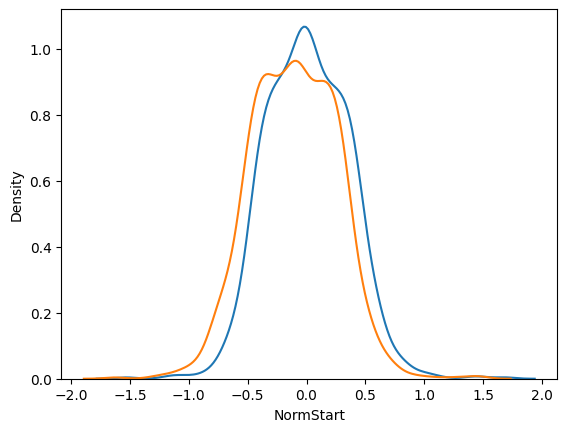

In [ ]:
import seaborn as sns
ax = (sns.kdeplot(data=rel_fix_df_4rocks, x='NormStart'),
        sns.kdeplot(data=rel_fix_df_4rocks, x='NormStop'))



In [ ]:
walkNum = butil.find_walks_with_type(3,'rocks')
walkNum = walkNum[1:7]
dataset = loading(3,walkNum,'rocks')
fix_df,stop,start = extract_fix(dataset)
steps_df = extract_steps(dataset)
closest_hs, fstart, fstop, closest_hs_df = find_closest_hs(fix_df,steps_df, stop, start)
rel_start,rel_stop, rel_fix_df = calc_rel_fix(closest_hs,fstart, fstop)
steps_df_new = time_diff(steps_df)
norm_st,norm_sp, rel_fix_df_new = norm(rel_fix_df,rel_start,rel_stop,steps_df_new,closest_hs_df)
rel_fix_df_3rocks = pd.concat(rel_fix_df_new)

In [ ]:
walkNum.pop()

12

In [ ]:
# rocks for each subject
rel_fix_rocks_pooled = []
for x in range(3,11):
    walkNum = butil.find_walks_with_type(x,'rocks')
    
    if x == 3:
        walkNum = walkNum[1:7]
    if x == 6:
        walkNum.pop(5)
        walkNum.pop(0)
        
    dataset = loading(x,walkNum,'rocks')
    fix_df,stop,start = extract_fix(dataset)
    steps_df = extract_steps(dataset)
    closest_hs, fstart, fstop, closest_hs_df = find_closest_hs(fix_df,steps_df, stop, start)
    rel_start,rel_stop, rel_fix_df = calc_rel_fix(closest_hs,fstart, fstop)
    steps_df_new = time_diff(steps_df)
    norm_st,norm_sp, rel_fix_df_new = norm(rel_fix_df,rel_start,rel_stop,steps_df_new,closest_hs_df)
    rel_fix_df_rocks = pd.concat(rel_fix_df_new)
    rel_fix_rocks_pooled.append(rel_fix_df_rocks)
    

In [ ]:
rel_fix_medium_pooled = []
for x in range(3,5):
    walkNum = butil.find_walks_with_type(x,'medium')
    dataset = loading(x,walkNum,'medium')
    fix_df,stop,start = extract_fix(dataset)
    steps_df = extract_steps(dataset)
    closest_hs, fstart, fstop, closest_hs_df = find_closest_hs(fix_df,steps_df, stop, start)
    rel_start,rel_stop, rel_fix_df = calc_rel_fix(closest_hs,fstart, fstop)
    steps_df_new = time_diff(steps_df)
    norm_st,norm_sp, rel_fix_df_new = norm(rel_fix_df,rel_start,rel_stop,steps_df_new,closest_hs_df)
    rel_fix_df_medium = pd.concat(rel_fix_df_new)
    rel_fix_medium_pooled.append(rel_fix_df_medium)
for x in range(6,11):
    walkNum = butil.find_walks_with_type(x,'medium')
    dataset = loading(x,walkNum,'medium')
    fix_df,stop,start = extract_fix(dataset)
    steps_df = extract_steps(dataset)
    closest_hs, fstart, fstop, closest_hs_df = find_closest_hs(fix_df,steps_df, stop, start)
    rel_start,rel_stop, rel_fix_df = calc_rel_fix(closest_hs,fstart, fstop)
    steps_df_new = time_diff(steps_df)
    norm_st,norm_sp, rel_fix_df_new = norm(rel_fix_df,rel_start,rel_stop,steps_df_new,closest_hs_df)
    rel_fix_df_medium = pd.concat(rel_fix_df_new)
    rel_fix_medium_pooled.append(rel_fix_df_medium)

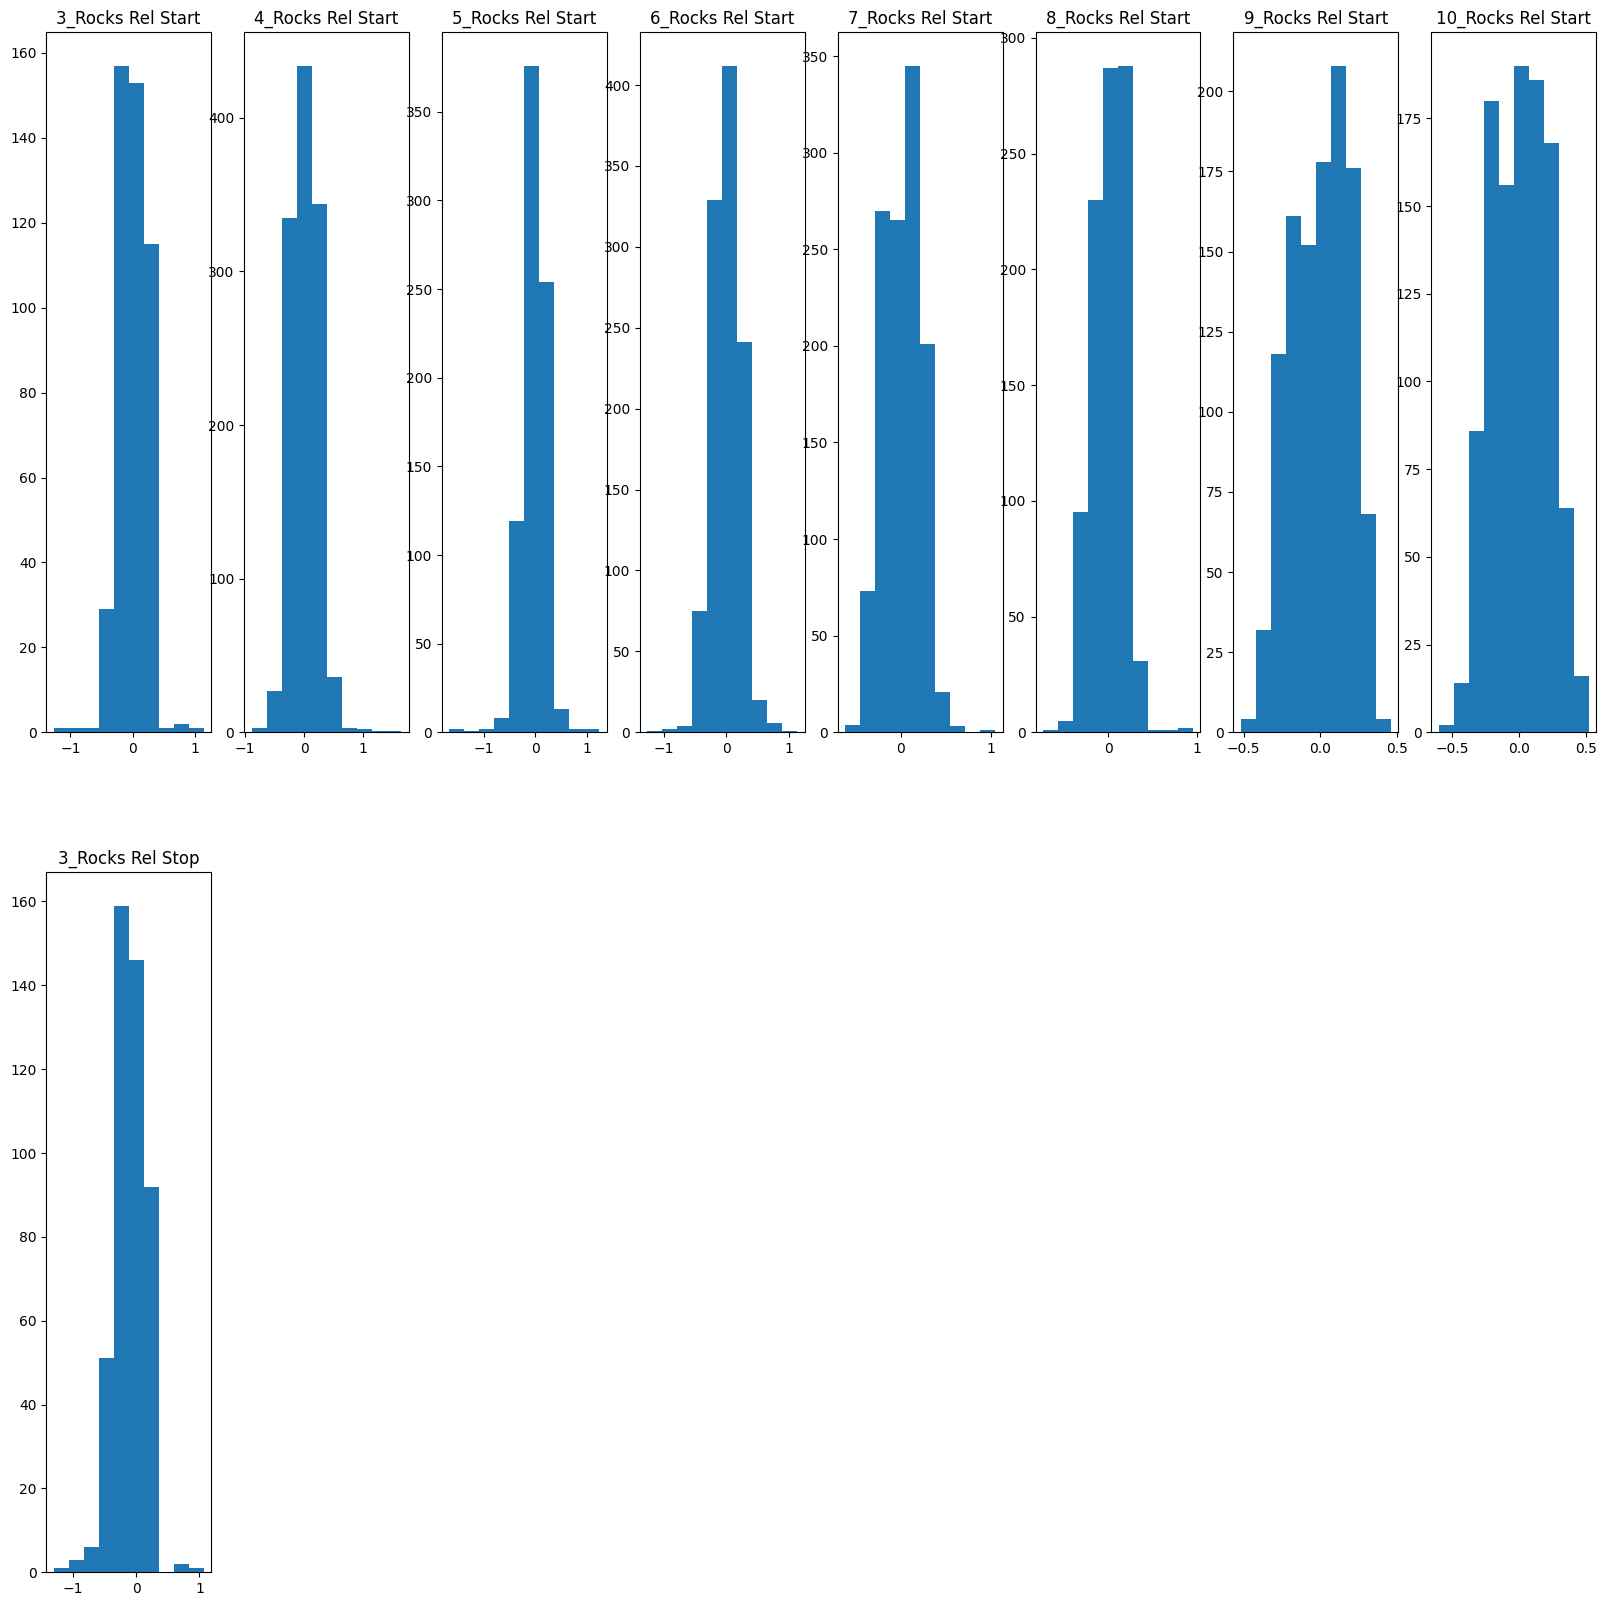

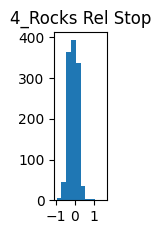

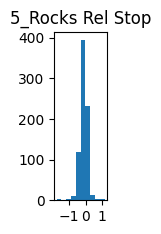

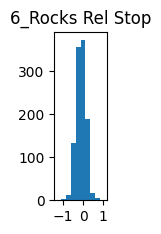

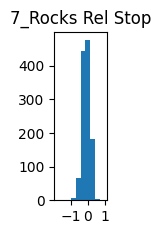

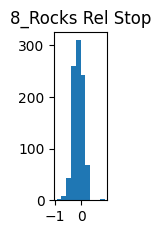

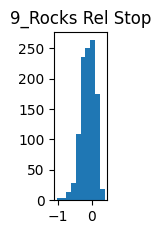

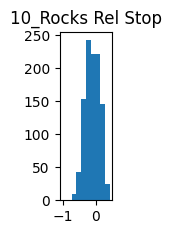

In [ ]:
plt.figure(figsize=(20,20))

s=2
for x,i in zip(rel_fix_rocks_pooled,range(len(rel_fix_rocks_pooled))):
    n = i + 1
    s += 1
    plt.subplot(2,8,n)
    plt.hist(x['RelStart'])
    plt.title(f'{s}_Rocks Rel Start')
    
s = 2
n = 8
for x,i in zip(rel_fix_rocks_pooled,range(len(rel_fix_rocks_pooled))):
    n += 1
    s += 1
    plt.subplot(2,8,n)
    plt.hist(x['RelStop'])
    plt.title(f'{s}_Rocks Rel Stop')
    
    plt.tight_layout
    plt.show()

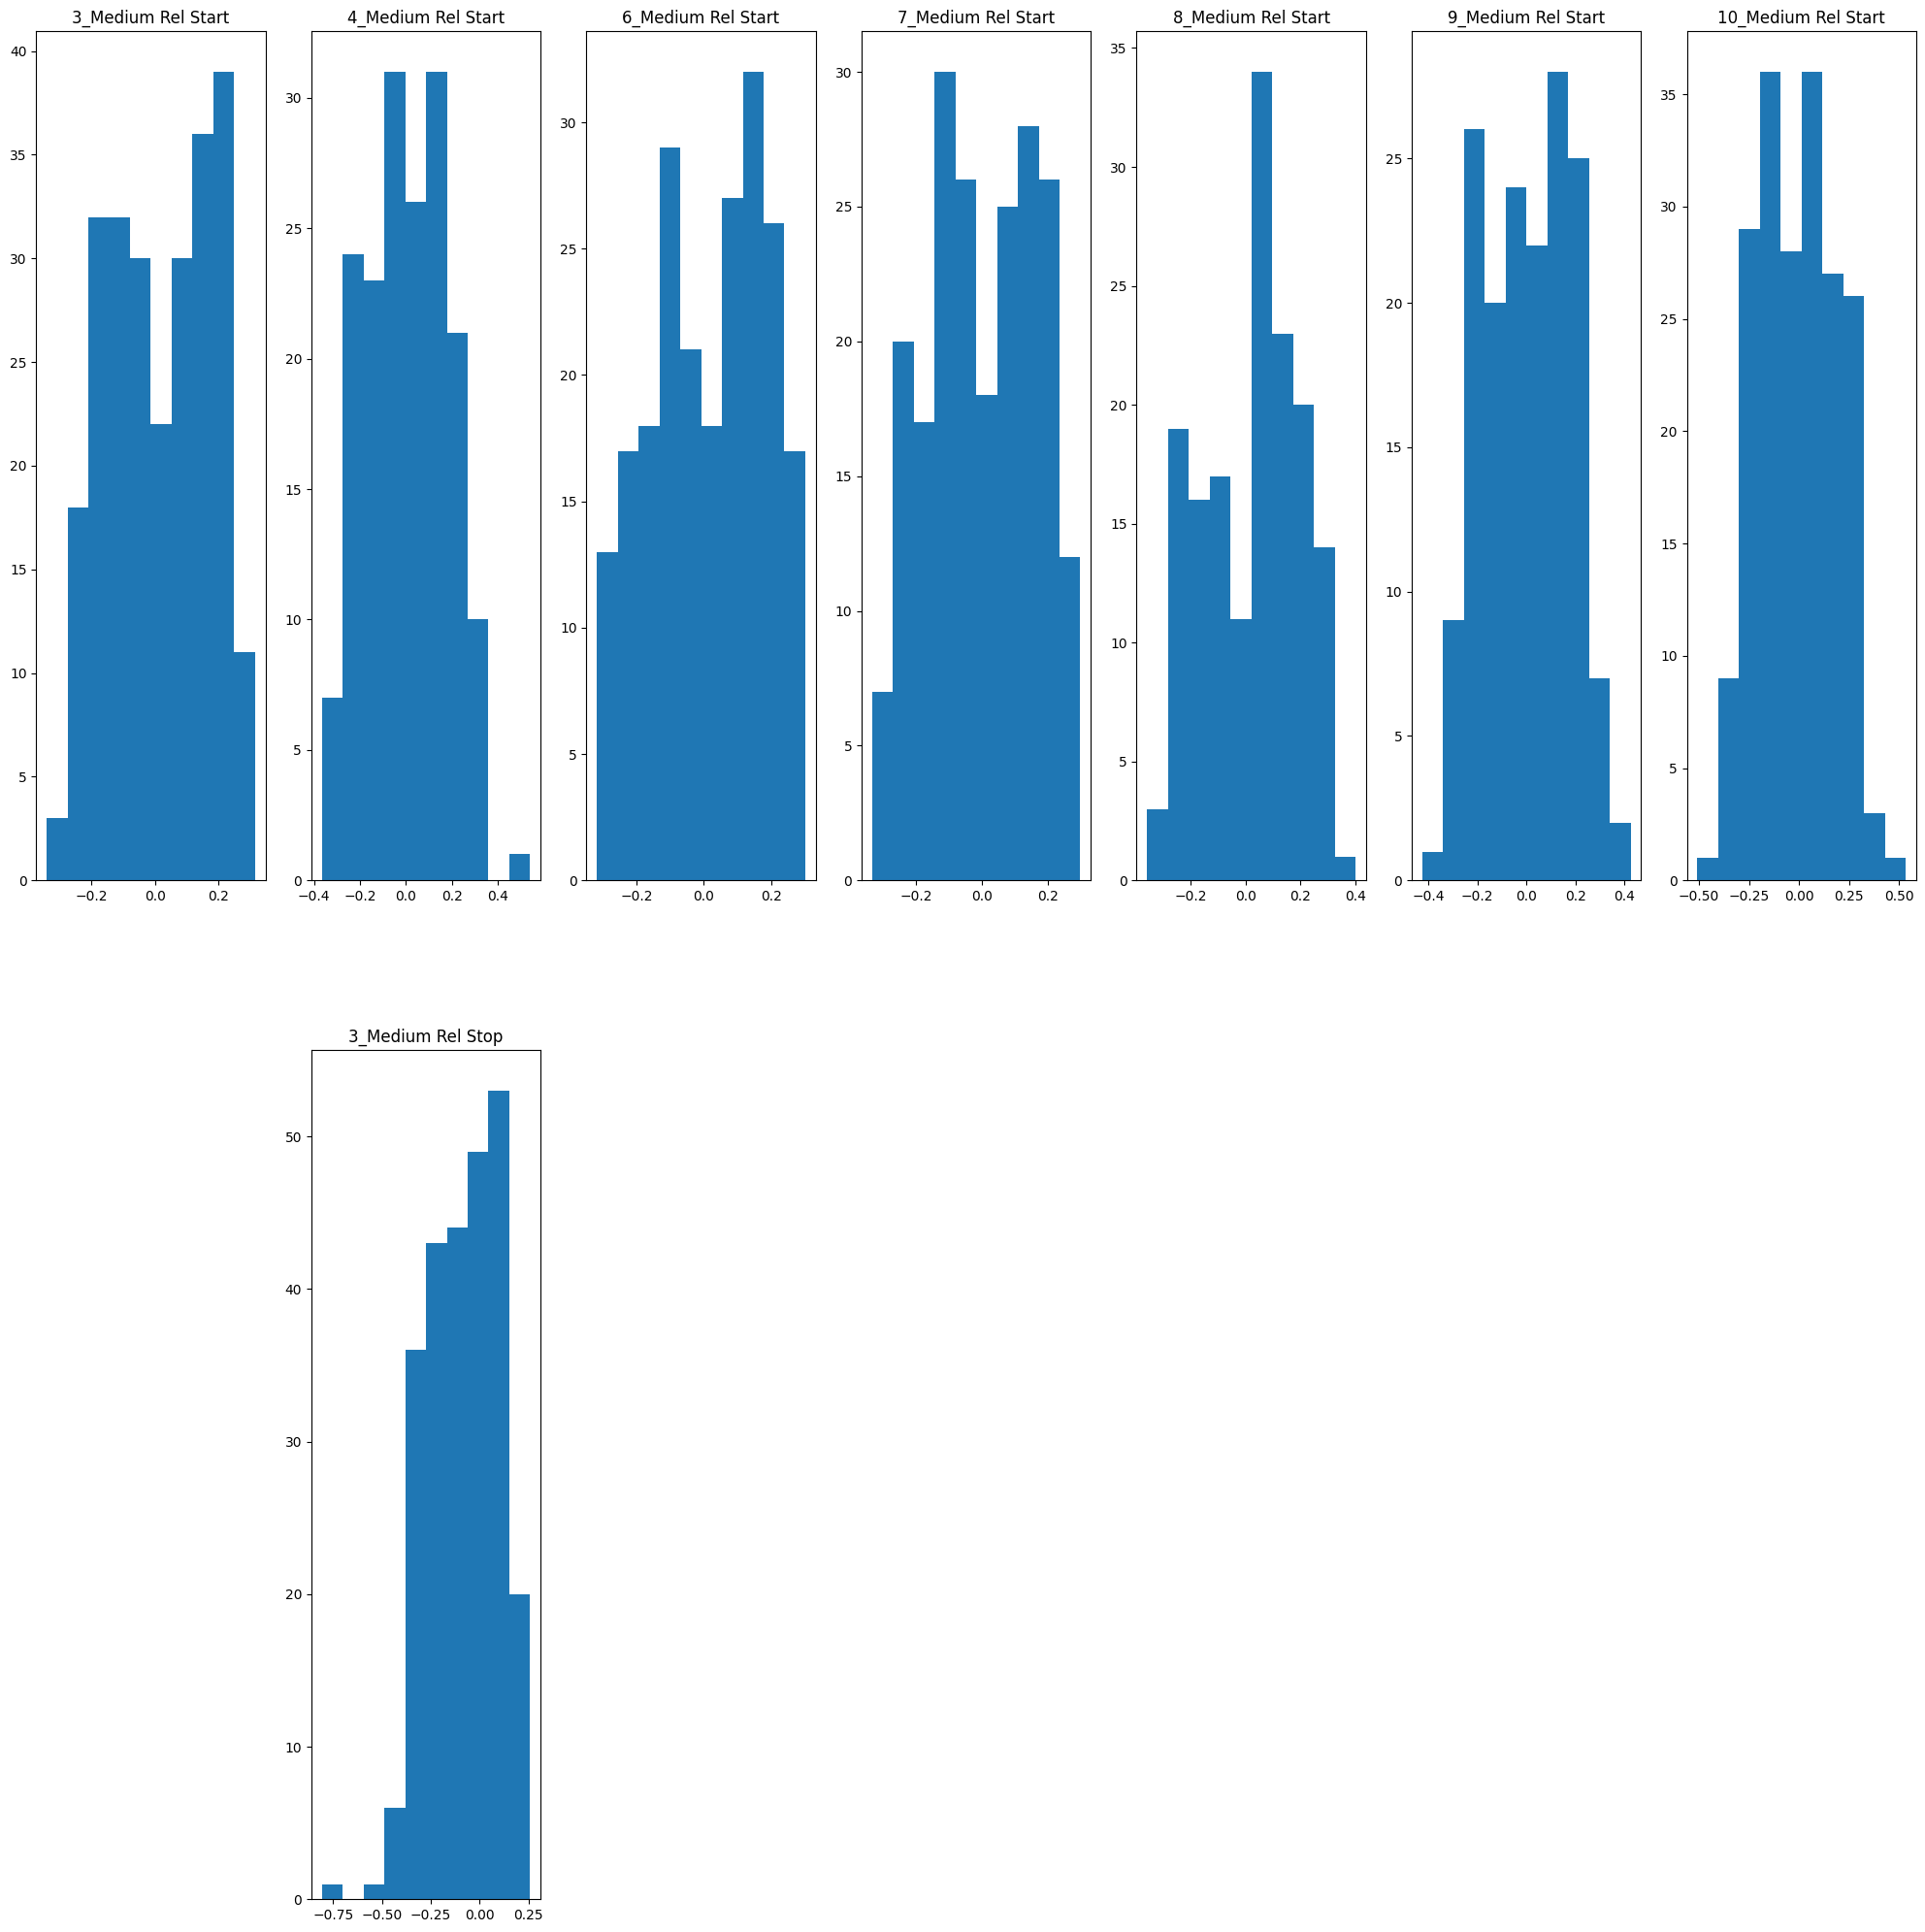

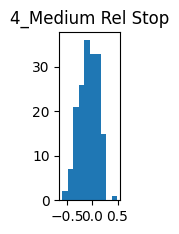

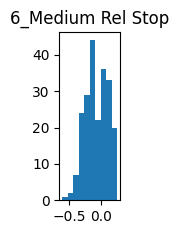

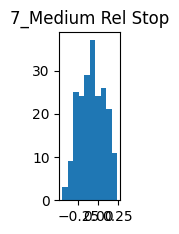

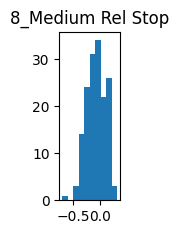

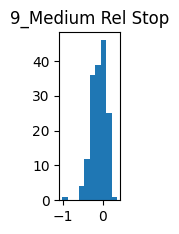

ValueError: num must be an integer with 1 <= num <= 14, not 15

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(25,25))

s=2
for x,i in zip(rel_fix_medium_pooled,range(len(rel_fix_medium_pooled))):
    n = i + 1
    s += 1
    if s == 5:
        s +=1
    plt.subplot(2,7,n)
    plt.hist(x['RelStart'])
    plt.title(f'{s}_Medium Rel Start')
    
s = 2
n = 7
for x,i in zip(rel_fix_medium_pooled,range(len(rel_fix_medium_pooled))):
    n += 1
    s += 1
    if s == 5:
        s +=1
    plt.subplot(2,7,n)
    plt.hist(x['RelStop'])
    plt.title(f'{s}_Medium Rel Stop')
    
    plt.tight_layout
    plt.show()

In [2]:

import json

#rock sample
with open("/N/project/berkeley_walking/BerkeleyData/berkeley_json/s5_12_rocks_allWalks.json", "r") as f:
    data = json.load(f)
with open("/N/project/berkeley_walking/BerkeleyData/berkeley_json/s5_12_rocks_allWalks.json", "w") as f:
    json.dump(data,f)

#medium sample
with open("/N/project/berkeley_walking/BerkeleyData/berkeley_json/s5_6_medium_allWalks.json", "r") as f:
    data_m = json.load(f)
with open("/N/project/berkeley_walking/BerkeleyData/berkeley_json/s5_6_medium_allWalks.json", "w") as f:
    json.dump(data_m,f)




In [6]:
#rock sample
with open("/N/project/berkeley_walking/BerkeleyData/berkeley_json/s3_15_rocks_allWalks.json", "r") as f:
    data = json.load(f)
with open("/N/project/berkeley_walking/BerkeleyData/berkeley_json/s3_15_rocks_allWalks.json", "w") as f:
    json.dump(data,f)

In [4]:
walkNum = [19, 10, 15]
import json

def loading(ID,walkNum):
    
    dataset = []
    for x in walkNum:
        loc = '/N/project/berkeley_walking/BerkeleyData/berkeley_json'
        with open(f'{loc}/s{ID}_{x}_rocks_allWalks.json', "r") as f:
            data = json.load(f)
        with open("/N/project/berkeley_walking/BerkeleyData/berkeley_json/s5_12_rocks_allWalks.json", "w") as f:
            json.dump(data,f)
        dataset.append(data)
    return dataset

d = loading(3,walkNum)


JSONDecodeError: Expecting value: line 1 column 16 (char 15)

In [9]:
framerate = data['framerate']

In [10]:
#medium and rock variables are defined on same line for most of remaining cells


frames,frames_m = np.array(data['frames']),np.array(data_m['frames'])
time,time_m = np.array(data['syncedUnixTime']), np.array(data_m['syncedUnixTime'])
time,time_m = time -time[0], time_m -time_m[0]


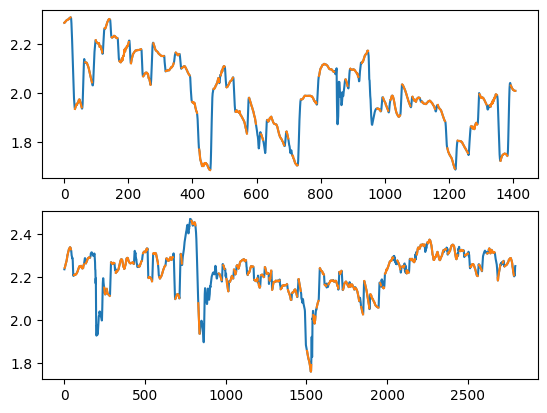

In [11]:
fixation,fixation_m = np.array(data['rEye_blinks'], dtype = bool), np.array(data_m['rEye_blinks'], dtype = bool)
theta,theta_m = np.array(data['rEye_theta']), np.array(data_m['rEye_theta'])
phi = np.array(data['rEye_phi'])
theta_fix, theta_fix_m = np.array(data['rEye_theta']), np.array(data_m['rEye_theta'])
theta_fix[fixation], theta_fix_m[fixation_m] = np.nan, np.nan

plt.subplot(2,1,1)
plt.plot(theta)
plt.plot(theta_fix)

plt.subplot(2,1,2)
plt.plot(theta_m)
plt.plot(theta_fix_m)

In [12]:
fixations_df,fixations_df_m = pd.DataFrame({ 'Frames': frames, 'Time': time, 'Theta': theta,
                             'ThetaFix': theta_fix}), pd.DataFrame({ 'Frames': frames_m, 'Time': time_m, 'Theta': theta_m,
                             'ThetaFix': theta_fix_m})

fixations_df, fixations_df_m = fixations_df.dropna(), fixations_df_m.dropna()
fixations_df['TimeDiffPrev'], fixations_df_m['TimeDiffPrev'] = fixations_df['Time'].diff(), fixations_df_m['Time'].diff()
fixations_df['TimeDiffFol'], fixations_df_m['TimeDiffFol'] = fixations_df['Time'].diff(periods=-1), fixations_df_m['Time'].diff(periods=-1)

FixEnd,FixEnd_m = fixations_df.loc[fixations_df['TimeDiffPrev'] > 0.009], fixations_df_m.loc[fixations_df_m['TimeDiffPrev'] > 0.009]
FixStart,FixStart_m = fixations_df.loc[fixations_df['TimeDiffFol'] < -0.009], fixations_df_m.loc[fixations_df_m['TimeDiffFol'] < -0.009]

In [13]:
steps, steps_m = np.array(data['steps_HS_TO_StanceLeg_XYZ']), np.array(data_m['steps_HS_TO_StanceLeg_XYZ']) #frame step start, frame step end, left/right, XYZ
step_start, step_start_m = steps[:,0].astype(int), steps_m[:,0].astype(int)
step_start_time, step_start_time_m = step_start / framerate, step_start_m / framerate

step_end,step_end_m = steps[:,1].astype(int), steps_m[:,1].astype(int)
step_end_time, step_end_time_m  = step_end / framerate, step_end_m / framerate


step_frames, step_frames_m = steps[:,0:2].astype(int), steps_m[:,0:2].astype(int)
step_time, step_time_m = step_frames.T / framerate, step_frames_m.T / framerate


In [14]:
steps_df, steps_df_m = pd.DataFrame({'FrameStart': steps[:,0], 'FrameEnd': steps[:,1], 'Foot':steps[:,2],
                         'X': steps[:,3],  'Y': steps[:,4],  'Z' :steps[:,5]}), pd.DataFrame({'FrameStart': steps_m[:,0], 'FrameEnd': steps_m[:,1], 'Foot':steps_m[:,2],
                         'X': steps_m[:,3],  'Y': steps_m[:,4],  'Z' :steps_m[:,5]})


steps_df['StartTime'], steps_df_m['StartTime']  = step_start_time, step_start_time_m
steps_df['EndTime'], steps_df_m['EndTime']  = step_end_time, step_end_time_m

right_foot = steps_df.loc[(steps_df['Foot'] == 2)]
left_foot = steps_df.loc[(steps_df['Foot'] == 1)]

(0.0, 1.6)

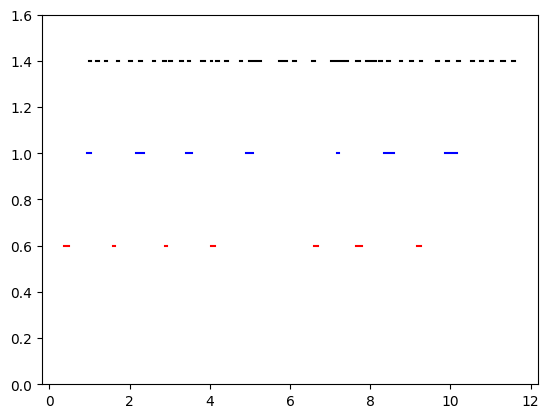

In [15]:
plt.plot((FixStart['Time'][3:], FixEnd['Time'][3:]), np.full_like((FixStart['Time'][3:],FixEnd['Time'][3:]),
                                                                           1.4, dtype=float), color = 'black')  

plt.plot((left_foot['StartTime'],left_foot['EndTime']), np.ones_like((left_foot['StartTime'],left_foot['EndTime'])), color = 'blue')
plt.plot((right_foot['StartTime'],right_foot['EndTime']), np.full_like((right_foot['StartTime'],right_foot['EndTime']),
                                                                            0.6, dtype=float), color = 'red')                                                       
plt.ylim(0,1.6)   

In [16]:
#getting variables for both medium and rock 
fixStart, fixStart_m = np.array(FixStart['Time']), np.array(FixStart_m['Time'])
fixEnd, fixEnd_m = np.array(FixEnd['Time']), np.array(FixEnd_m['Time'])
footfalls, footfalls_m =np.array(steps_df['StartTime']), np.array(steps_df_m['StartTime']) #heel strike

footfalls, footfalls_m = footfalls.reshape(-1,1), footfalls_m.reshape(-1,1)
fixStart, fixStart_m = fixStart.reshape(-1,1), fixStart_m.reshape(-1,1)
fixStop, fixStop_m = fixEnd.reshape(-1,1), fixEnd_m.reshape(-1,1)



#nearest neighbor rock
from sklearn.neighbors import NearestNeighbors

X = footfalls
Start = fixStart
Stop = fixStop

neigh = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(X)

    
start_distances, start_indices = neigh.kneighbors(Start)


startNearest = np.array(start_indices)

    

In [17]:
#nearest neighbor for medium
neigh = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(footfalls_m)

start_distances_m, start_indices_m = neigh.kneighbors(fixStart_m)


startNearest_m = np.array(start_indices_m)



In [18]:
#adding the nearest heel strike time to the fixation start (medium and rock)
closest_heelstrike_time, closest_heelstrike_time_m = footfalls[startNearest], footfalls_m[startNearest_m]
closest_heelstrike_time, closest_heelstrike_time_m = closest_heelstrike_time[:,0], closest_heelstrike_time_m[:,0]


nearestFootfalls, nearestFootfalls_m = pd.DataFrame(closest_heelstrike_time, columns = ['TimeNearFixStart']), pd.DataFrame(closest_heelstrike_time_m, columns = ['TimeNearFixStart'])
nearestFootfalls['IndexNearFixStart'], nearestFootfalls_m['IndexNearFixStart'] = startNearest, startNearest_m


Text(0.5, 0, 'time(s)')

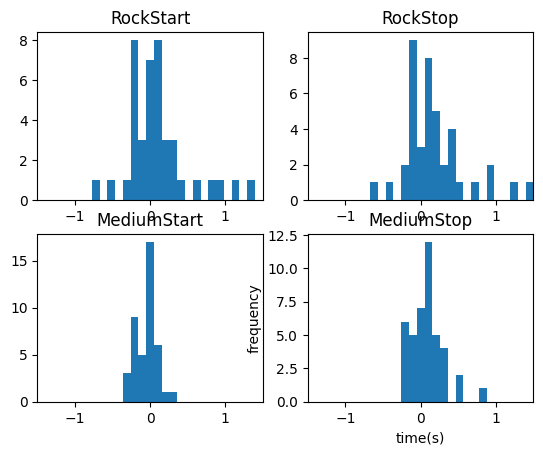

In [19]:
rel_start = []
rel_stop = []
rel_start_m = []
rel_stop_m = []

for x, y,xm,ym in zip(Start,closest_heelstrike_time,fixStart_m,closest_heelstrike_time_m):
    z,zm = x - y, xm-ym
    rel_start.append(z)
    rel_start_m.append(zm)

for x, y,xm,ym in zip(Stop,closest_heelstrike_time,fixStop_m,closest_heelstrike_time_m):
    z,zm = x - y, xm-ym
    rel_stop.append(z)
    rel_stop_m.append(zm)

rel_start_time, rel_start_time_m = np.array(rel_start), np.array(rel_start_m)
rel_stop_time, rel_stop_time_m = np.array(rel_stop), np.array(rel_stop_m)

bins = np.linspace(-1.5,1.5,num=30)

plt.subplot(2,2,1)
plt.hist(rel_start_time[:,0],bins=bins)
plt.title('RockStart')
plt.xlim((-1.5,1.5))


plt.subplot(2,2,2)
plt.hist(rel_stop_time[:,0],bins=bins)
plt.title('RockStop')
plt.xlim((-1.5,1.5))

plt.subplot(2,2,3)
plt.hist(rel_start_time_m[:,0],bins=bins)
plt.title('MediumStart')
plt.xlim((-1.5,1.5))


plt.subplot(2,2,4)
plt.hist(rel_stop_time_m[:,0],bins=bins)
plt.title('MediumStop')
plt.xlim((-1.5,1.5))
plt.ylabel('frequency')
plt.xlabel('time(s)')

<Axes: xlabel='RelStart', ylabel='Density'>

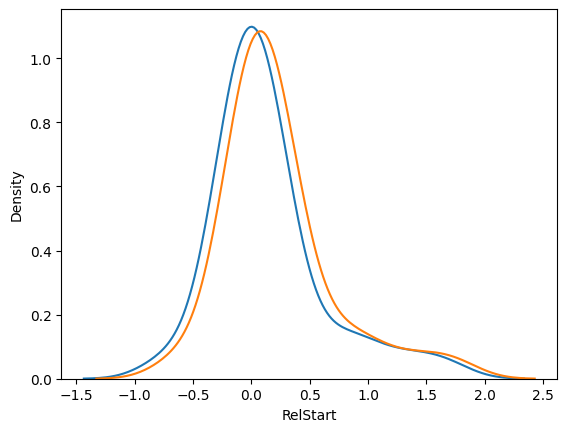

In [20]:
#rel start and stop for rock
import seaborn as sns

rel_start_time = rel_start_time[:,0]
rel_stop_time = rel_stop_time[:,0]

RelFixTimes = pd.DataFrame(rel_start_time, columns=['RelStart'])
RelFixTimes['RelStop'] = rel_stop_time

sns.kdeplot(data=RelFixTimes, x='RelStart')
sns.kdeplot(data=RelFixTimes, x='RelStop')


<Axes: xlabel='RelStart', ylabel='Density'>

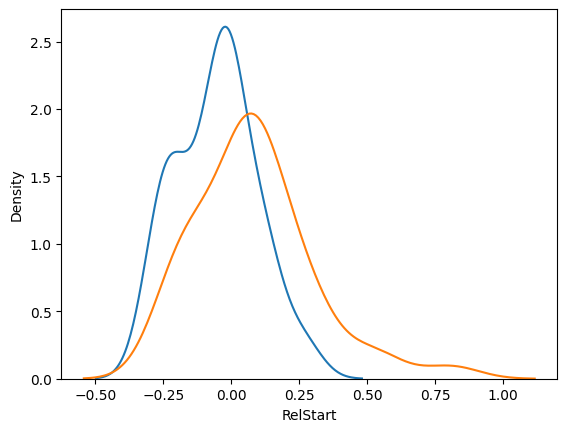

In [21]:
#rel start and stop for medium
import seaborn as sns

rel_start_time_m = rel_start_time_m[:,0]
rel_stop_time_m = rel_stop_time_m[:,0]

RelFixTimes_m = pd.DataFrame(rel_start_time_m, columns=['RelStart'])
RelFixTimes_m['RelStop'] = rel_stop_time_m

sns.kdeplot(data=RelFixTimes_m, x='RelStart')
sns.kdeplot(data=RelFixTimes_m, x='RelStop')

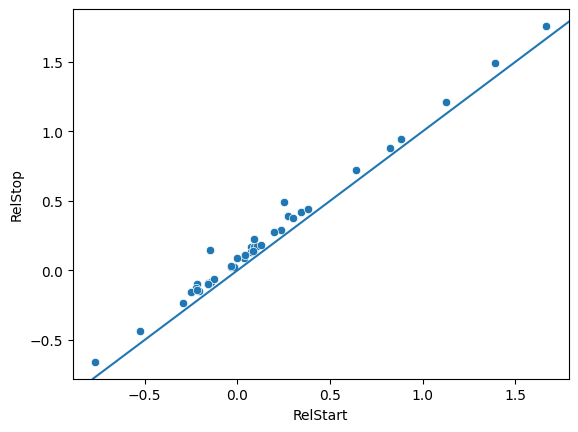

In [22]:
sns.scatterplot(data=RelFixTimes, x='RelStart', y='RelStop')
plt.axline((0,0),(1,1))

<Axes: xlabel='RelStart', ylabel='FixationDuration'>

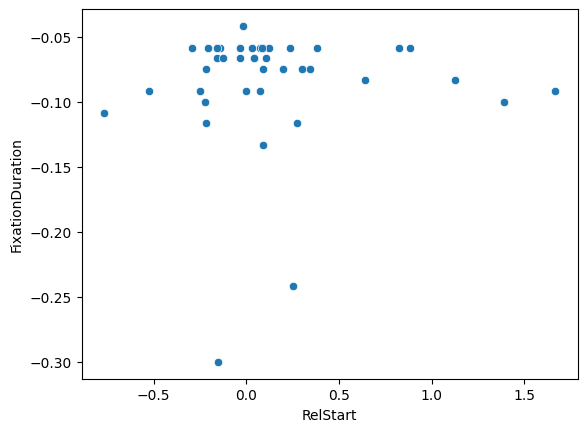

In [23]:
RelFixTimes['FixationDuration'] = RelFixTimes['RelStart'] - RelFixTimes['RelStop']

sns.scatterplot(data=RelFixTimes, x='RelStart', y='FixationDuration')

In [24]:
#subtracting previous and next steps in each dataframe, missing stopnext
steps_df['nextdiff'] = steps_df['StartTime'].diff(-1).abs()
steps_df['nextdiffStop'] = steps_df ['StartTime'].diff(-1).abs()
steps_df['prevdiff'] = steps_df['StartTime'].diff()
steps_df['prevdiffStop'] = steps_df['EndTime'].diff()

steps_df_m['nextdiff'] = steps_df_m['StartTime'].diff(-1).abs()
steps_df_m['prevdiff'] = steps_df_m['StartTime'].diff()

In [25]:
steps_df

,FrameStart,FrameEnd,Foot,X,Y,Z,StartTime,EndTime,nextdiff,nextdiffStop,prevdiff,prevdiffStop
0,45.0,58.0,2.0,522.415917,12756.283105,-282.773751,0.375000,0.483333,0.566667,0.608333,NaN,NaN
1,113.0,125.0,1.0,1217.909809,12746.328993,-782.686092,0.941667,1.041667,0.641667,0.533333,0.566667,0.558333
2,190.0,196.0,2.0,1941.212326,12686.503843,-835.406296,1.583333,1.633333,0.566667,0.558333,0.641667,0.591667
3,258.0,283.0,1.0,2638.543084,12785.869388,-846.843552,2.150000,2.358333,0.725000,0.516667,0.566667,0.725000
4,345.0,352.0,2.0,3044.437374,12823.988955,-315.569505,2.875000,2.933333,0.541667,0.541667,0.725000,0.575000
5,410.0,426.0,1.0,3481.118904,12765.902020,-97.486511,3.416667,3.550000,0.625000,0.550000,0.541667,0.616667
6,485.0,497.0,2.0,4057.450074,12776.703944,455.111351,4.041667,4.141667,0.850000,0.583333,0.625000,0.591667
7,587.0,610.0,1.0,4528.075706,12694.484682,809.000216,4.891667,5.083333,1.700000,0.566667,0.850000,0.941667
8,791.0,805.0,2.0,5121.244749,12601.752266,767.114027,6.591667,6.708333,0.575000,0.641667,1.700000,1.625000
9,860.0,868.0,1.0,5432.838195,12358.503872,870.213927,7.166667,7.233333,0.483333,0.558333,0.575000,0.525000


In [26]:
steps_df_m

,FrameStart,FrameEnd,Foot,X,Y,Z,StartTime,EndTime,nextdiff,nextdiffStop,prevdiff,prevdiffStop
0,46.0,61.0,1.0,853.789829,-576.839599,-173.268521,0.383333,0.508333,0.608333,0.608333,NaN,NaN
1,119.0,131.0,2.0,1552.302830,-540.264052,-183.055446,0.991667,1.091667,0.533333,0.533333,0.608333,0.583333
2,183.0,200.0,1.0,2114.726380,-539.576378,-127.422442,1.525000,1.666667,0.558333,0.558333,0.533333,0.575000
3,250.0,262.0,2.0,2726.376439,-556.849775,-51.267777,2.083333,2.183333,0.516667,0.516667,0.558333,0.516667
4,312.0,325.0,1.0,3246.171346,-560.128979,297.582341,2.600000,2.708333,0.541667,0.541667,0.516667,0.525000
5,377.0,386.0,2.0,3940.906545,-598.721589,627.479702,3.141667,3.216667,0.550000,0.550000,0.541667,0.508333
6,443.0,456.0,1.0,4745.767498,-570.429118,804.506761,3.691667,3.800000,0.583333,0.583333,0.550000,0.583333
7,513.0,525.0,2.0,5560.391948,-449.986229,905.209126,4.275000,4.375000,0.566667,0.566667,0.583333,0.575000
8,581.0,601.0,1.0,6339.300456,-275.890670,951.652189,4.841667,5.008333,0.641667,0.641667,0.566667,0.633333
9,658.0,672.0,2.0,7090.335104,-158.928636,869.877895,5.483333,5.600000,0.558333,0.558333,0.641667,0.591667


In [27]:
#normalizing start and stop times for rock
NormStart = []

for x,y in zip(RelFixTimes['RelStart'],range(len(rel_start))):
        z = nearestFootfalls['IndexNearFixStart'][y]
        if z==0 and y==0:
                norm = x / nearestFootfalls['TimeNearFixStart'][y] - 0
        elif x <=0:
                norm = x / steps_df['prevdiff'][z]
        elif x >=0:
                norm = x / steps_df['nextdiff'][z]
        NormStart.append(norm)

NormStop = []

for x,y in zip(RelFixTimes['RelStop'],range(len(rel_stop))):
        z = nearestFootfalls['IndexNearFixStart'][y]
        if z==0 and y==0:
                norm = x / nearestFootfalls['TimeNearFixStart'][y] - 0
        elif x <=0:
                norm = x / steps_df['prevdiff'][z]
        elif x >=0:
                norm = x / steps_df['nextdiff'][z]
        NormStop.append(norm)



In [31]:
nearestFootfalls

,TimeNearFixStart,IndexNearFixStart
0,0.375000,0
1,0.375000,0
2,0.941667,1
3,0.941667,1
4,0.941667,1
5,1.583333,2
6,1.583333,2
7,2.150000,3
8,2.150000,3
9,2.875000,4


In [40]:
#normalizing start and stop times for medium

NormStart_m = []

for x,y in zip(RelFixTimes_m['RelStart'],range(len(rel_start_m))):
        z = nearestFootfalls_m['IndexNearFixStart'][y]
        if z==0 and y==0:
                norm = x / nearestFootfalls_m['TimeNearFixStart'][y] - 0
        elif x <=0:
                norm = x / steps_df_m['prevdiff'][z]
        elif x >=0:
                norm = x / steps_df_m['nextdiff'][z]
        NormStart_m.append(norm)

NormStop_m = []

for x,y in zip(RelFixTimes_m['RelStop'],range(len(rel_stop_m))):
        z = nearestFootfalls_m['IndexNearFixStart'][y]
        if z==0 and y==0:
                norm = x / nearestFootfalls_m['TimeNearFixStart'][y] - 0
        elif x <=0:
                norm = x / steps_df_m['prevdiffStop'][z]
        elif x >=0:
                norm = x / steps_df_m['nextdiffStop'][z]
        NormStop_m.append(norm)

In [41]:
#adding Norm values to respective dataframes
RelFixTimes['NormStart'] = NormStart
RelFixTimes['NormStop'] = NormStop

RelFixTimes_m['NormStart'] = NormStart_m
RelFixTimes_m['NormStop'] = NormStop_m


<Axes: xlabel='NormStart', ylabel='Density'>

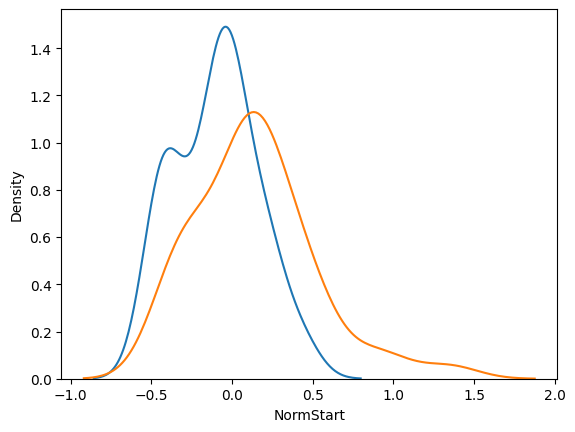

In [42]:
sns.kdeplot(data=RelFixTimes_m, x='NormStart')
sns.kdeplot(data=RelFixTimes_m, x='NormStop')

<Axes: xlabel='NormStart', ylabel='Density'>

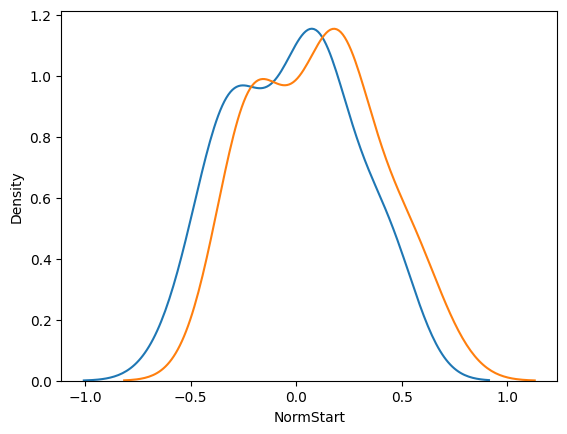

In [43]:
sns.kdeplot(data=RelFixTimes, x='NormStart')
sns.kdeplot(data=RelFixTimes, x='NormStop')

<Axes: xlabel='NormStart', ylabel='Density'>

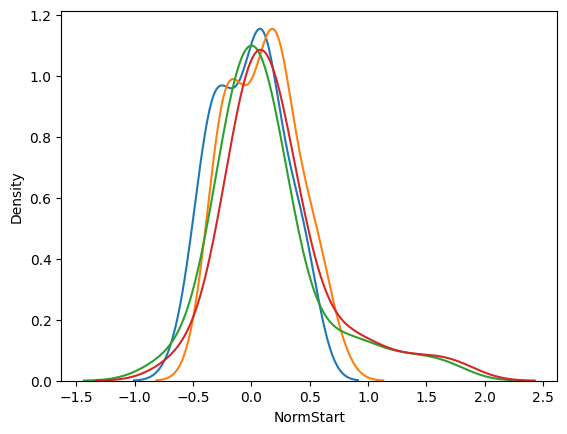

In [44]:
#normalized/fraction of a step rock

sns.kdeplot(data=RelFixTimes, x='NormStart')
sns.kdeplot(data=RelFixTimes, x='NormStop')
sns.kdeplot(data=RelFixTimes, x='RelStart')
sns.kdeplot(data=RelFixTimes, x='RelStop')


<Axes: xlabel='NormStart', ylabel='Density'>

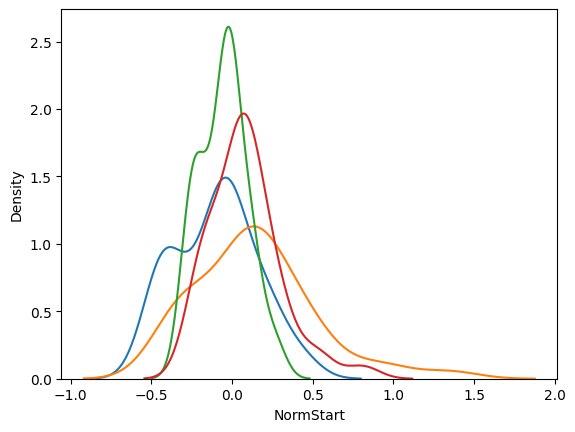

In [45]:
#normalized/fraction of a step medium

sns.kdeplot(data=RelFixTimes_m, x='NormStart')
sns.kdeplot(data=RelFixTimes_m, x='NormStop')
sns.kdeplot(data=RelFixTimes_m, x='RelStart')
sns.kdeplot(data=RelFixTimes_m, x='RelStop')


    

Text(0, 0.5, 'TimeDiff')

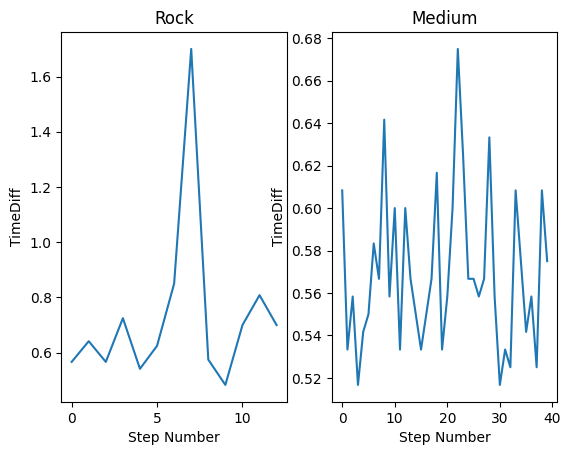

In [46]:
#find step velocity for terrains and compare regressions?
# need distance between steps for vel
#nextdiff here is only for start,left out stop

plt.subplot(1,2,1)
plt.plot(steps_df['nextdiff'])
plt.title('Rock')
plt.xlabel('Step Number')
plt.ylabel('TimeDiff')

plt.subplot(1,2,2)
plt.plot(steps_df_m['nextdiff'])
plt.title('Medium')
plt.xlabel('Step Number')
plt.ylabel('TimeDiff')